<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Loading-Image-Data" data-toc-modified-id="Loading-Image-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Loading Image Data</a></span><ul class="toc-item"><li><span><a href="#Initial-Examination" data-toc-modified-id="Initial-Examination-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Initial Examination</a></span><ul class="toc-item"><li><span><a href="#Exercise:-Make-a-plot-of-a-slice-of-the-brain." data-toc-modified-id="Exercise:-Make-a-plot-of-a-slice-of-the-brain.-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span><em>Exercise</em>: Make a plot of a slice of the brain.</a></span></li></ul></li><li><span><a href="#Filling-an-xArray-Dataset" data-toc-modified-id="Filling-an-xArray-Dataset-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Filling an xArray Dataset</a></span></li></ul></li><li><span><a href="#Visualizing-Image-Data" data-toc-modified-id="Visualizing-Image-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Visualizing Image Data</a></span><ul class="toc-item"><li><span><a href="#Simple-Slice-Viewing-with-Holoviews" data-toc-modified-id="Simple-Slice-Viewing-with-Holoviews-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Simple Slice Viewing with Holoviews</a></span><ul class="toc-item"><li><span><a href="#Exercise:-Why-do-we-have-to-flip-the-y-axis?-How-can-we-do-this-within-the-data,-before-plotting?" data-toc-modified-id="Exercise:-Why-do-we-have-to-flip-the-y-axis?-How-can-we-do-this-within-the-data,-before-plotting?-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span><em>Exercise</em>: Why do we have to flip the y axis? How can we do this within the data, before plotting?</a></span></li></ul></li><li><span><a href="#Multi-slice-Viewing" data-toc-modified-id="Multi-slice-Viewing-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Multi-slice Viewing</a></span></li><li><span><a href="#Investigative-Plots" data-toc-modified-id="Investigative-Plots-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Investigative Plots</a></span><ul class="toc-item"><li><span><a href="#Exercise:-What-are-the-downsides-of-Boxplots?" data-toc-modified-id="Exercise:-What-are-the-downsides-of-Boxplots?-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span><em>Exercise</em>: What are the downsides of Boxplots?</a></span></li></ul></li><li><span><a href="#Alpha-Blending" data-toc-modified-id="Alpha-Blending-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Alpha Blending</a></span></li></ul></li><li><span><a href="#Scaling-Up" data-toc-modified-id="Scaling-Up-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Scaling Up</a></span></li></ul></div>

# Medical Imaging Analysis and xArray
Computer vision projects are commonplace in data science.  Typically, we have a large set of input images that need some sort of preprocessing and manipulation before we can crank them through some sort of ML architecture.  Ideally, we would like to have all images in a data structure in which we can quickly and easily analyze their content, perform operations, group and index, assign metadata and additional features, and so on.  Also, it would be nice if we could use a similar structure and API to `pandas` in order to minimize aggravation on our end.

[xArray](http://xarray.pydata.org/en/stable/) is a data structure built with multi-dimensional data in mind.  It is modeled very closely after `pandas`, and can be used to store a large set of images and additional data.

The dataset we'll be examining is a series of abdominal MRI sequences.

## Loading Image Data
Medical image data is typically stored as one of a number of image formats (DICOM, Nifti, MGH, etc), in order to maintain necessary metadata that corresponds to (among other things) the physical origin and spacing between the pixels of an image.  This information is not including in a simple array, which is needed when eventually invoking a tool like `pytorch`.  Because of this, we'll need to use a DICOM/Nifti image reader, so we'll be using `SimpleITK` to help with some image manipulation.

In [1]:
# Autoload if needed
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Plotting setup
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,8)

# Basic imports
import sys, os
import numpy as np
import pandas as pd
import xarray as xr
import SimpleITK as sitk
import nibabel as nib
import pickle as pkl
from pathlib import Path



### Initial Examination
We're going to look at brain images for this module.

In [3]:
ls /pghbio/dbmi/batmanlab/Data/BrainSegmentationData/GSP

081028_BC77WB_FS/  091111_DH33ZB_FS/  100629_PG65NB_FS/  110306_UK67WU_FS/
081028_KX46NB_FS/  091111_RZ64EH_FS/  100629_QQ62KH_FS/  110306_XQ57HU_FS/
081028_XE45TK_FS/  091112_CD32NB_FS/  100629_YF56YU_FS/  110307_CQ66NU_FS/
081028_YY28TK_FS/  091112_CS59AB_FS/  100630_TN86ZB_FS/  110307_QN49PU_FS/
081030_NC89WB_FS/  091112_EJ49VH_FS/  100630_ZG38MH_FS/  110307_RB77XH_FS/
081101_HG45HB_FS/  091112_GZ96FB_FS/  100701_FU35VB_FS/  110307_RK83RU_FS/
081101_JE65DB_FS/  091112_MV73MU_FS/  100701_HV73ST_FS/  110307_RW89FK_FS/
081101_NK25FK_FS/  091112_SF43WK_FS/  100701_KR62HB_FS/  110307_XU48XB_FS/
081101_XC45YB_FS/  091112_TQ43TU_FS/  100701_MK84PU_FS/  110308_DB38DT_FS/
081104_CK37CB_FS/  091115_GX64PH_FS/  100701_NG34YU_FS/  110308_RK69NM_FS/
081104_UG89XK_FS/  091115_NP57UH_FS/  100701_VT78YB_FS/  110308_UN68FT_FS/
081106_FF46TK_FS/  091115_NT43KU_FS/  100702_AZ38EH_FS/  110309_DD46SP_FS/
081106_KS67DK_FS/  091115_RS68TH_FS/  100702_DH48KB_FS/  110310_JH34KU_FS/
081108_CH36DK_FS/  091115

In [4]:
ls /pghbio/dbmi/batmanlab/Data/BrainSegmentationData/GSP/140820_YF58DB_FS

aseg.mgz*  norm.mgz*  stats/


In [5]:
# Set up the full path to the data
data_dir = '/pghbio/dbmi/batmanlab/Data/BrainSegmentationData/GSP'
# load in a sample image using nibabel
test_path = data_dir+'/140820_YF58DB_FS/norm.mgz'
test_data = nib.load(test_path)

In [6]:
print(test_data.header)

<class 'nibabel.freesurfer.mghformat.MGHHeader'> object, endian='>'
version      : 1
dims         : [256 256 256   1]
type         : 0
dof          : 0
goodRASFlag  : 1
delta        : [1. 1. 1.]
Mdc          : [[-1.00000000e+00  5.96046448e-08  1.11758702e-07]
 [ 2.30967956e-07 -5.54136648e-08 -1.00000000e+00]
 [ 1.34110437e-07  1.00000000e+00  1.02445625e-08]]
Pxyz_c       : [  1.8625641  50.90567   -16.417892 ]
tr           : 2200.0
flip_angle   : 0.0
te           : 0.0
ti           : 0.0
fov          : 256.0


What does the above information tell us? Importantly, we have an image of 256x256x256 pixels with 1 value per pixel.  The physical spacing is 1mm per pixel.  There is a rotation matrix defining the transformation from image space to physical space.  For more info, follow this link: https://surfer.nmr.mgh.harvard.edu/fswiki/FsTutorial/MghFormat

#### *Exercise*: Make a plot of a slice of the brain.

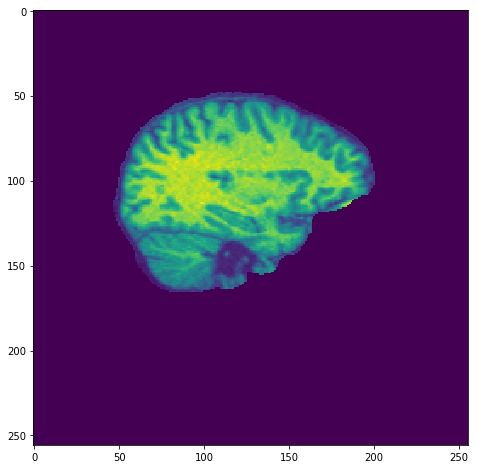

In [7]:
test_img = test_data.get_fdata()
# plt.imshow(test_img) # What's wrong here?
# plt.imshow(test_img[0,:,:]) # What's wrong here?
plt.imshow(test_img[100,:,:]) # What's wrong here?

Let's grab the segmentation for this brain as well.  Each subject has a segmentation map that highlights and labels different parts of the brain.  Without this information, our ability to do any kind of supervised learning is greatly diminished! Now-a-days, images are a dime a dozen, but labeled images are priceless!

In [8]:
test_seg = nib.load(data_dir+'/140820_YF58DB_FS/aseg.mgz')

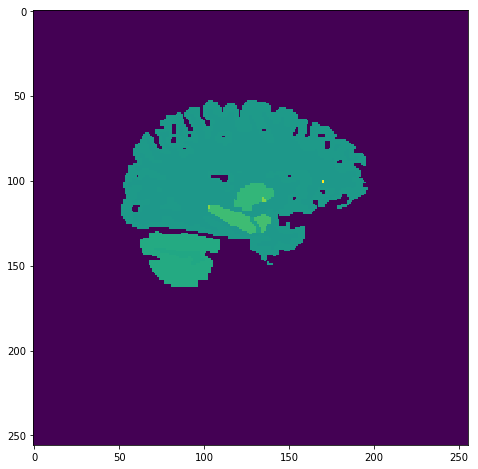

In [9]:
plt.imshow(test_seg.get_fdata()[100,:,:])

The pieces are ready to go, but as it currently stands, they are not in format in which we can easily perform large-scale investigation over the entire dataset.  It would be very convenient if we could load all patients into an object that allowed quick, easy, transparent access to the data. Let's take a look at xArray.

### Filling an xArray Dataset
xArray is the multidimensional analogue to pandas.  This makes it a very attractive tool when dealing with medical imaging (especially when all the images are very uniform in shape). A Dataset has `dims`, `data_vars`, and `coords` (and user-defined `attrs` for metadata).  Let's make a simple dataset then examine it's properties.

In [10]:
ds_test = xr.Dataset({'image':(['sequence', 'x', 'y', 'z'],
                               [test_data.get_fdata(), test_seg.get_fdata()]
                              )
                     },
                     coords={'sequence':['MRI', 'Seg'],
                             'x':range(256),
                             'y':range(256),
                             'z':range(256)}
                    )
# Calling the dataset prints out the dimensions, the coordinates, and the data_vars
ds_test

<xarray.Dataset>
Dimensions:   (sequence: 2, x: 256, y: 256, z: 256)
Coordinates:
  * sequence  (sequence) <U3 'MRI' 'Seg'
  * x         (x) int64 0 1 2 3 4 5 6 7 8 ... 248 249 250 251 252 253 254 255
  * y         (y) int64 0 1 2 3 4 5 6 7 8 ... 248 249 250 251 252 253 254 255
  * z         (z) int64 0 1 2 3 4 5 6 7 8 ... 248 249 250 251 252 253 254 255
Data variables:
    image     (sequence, x, y, z) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

We can now query our image data in an obvious, verbose way without bothering with keeping track of indexes.

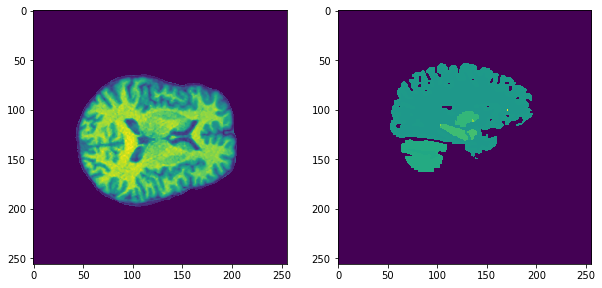

In [11]:
fig, axes = plt.subplots(1, 2)
axes = np.ravel(axes)
axes[0].imshow(ds_test.sel(sequence='MRI', y=100).image)
axes[1].imshow(ds_test.sel(sequence='Seg', x=100).image)

Text(0.5, 1.0, 'Image of Brain Averaged over Y')

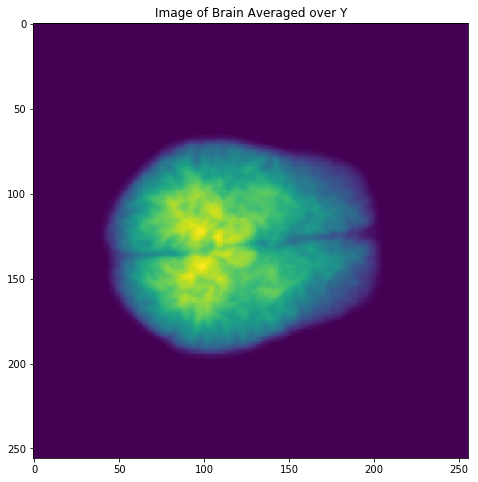

In [12]:
# We can also perform operations on that data that might be useful for analysis and computation.
plt.imshow(ds_test.sel(sequence='MRI').image.mean('y'))
plt.title('Image of Brain Averaged over Y')

In [13]:
# Load up a second patient to create a minimal example
test_data2 = nib.load(data_dir+'/091107_UU55XU_FS/norm.mgz')
test_seg2 = nib.load(data_dir+'/091107_UU55XU_FS/aseg.mgz')

In [14]:
test_data.header['delta']

array([1., 1., 1.], dtype=float32)

In [15]:
# Allocate space for an xarray object and assign names
ds = xr.Dataset({'MRI': (['subject', 'w', 'h', 'd'],
                            np.zeros((2, 256, 256, 256), dtype=np.float32)),
                 'seg': (['subject', 'w', 'h', 'd'],
                            np.zeros((2, 256, 256, 256), dtype=np.float32)),
                 'spacing': (['subject', 'dw_dh_dd'],
                            np.zeros((2,3), dtype=np.float32)),
                },
                coords={'subject': ['140820_YF58DB_FS', '091107_UU55XU_FS'],
                       'w':range(256),
                       'h':range(256),
                       'd':range(256),
                       'dw_dh_dd':[0,1,2]}
               )

In [16]:
ds

<xarray.Dataset>
Dimensions:   (d: 256, dw_dh_dd: 3, h: 256, subject: 2, w: 256)
Coordinates:
  * subject   (subject) <U16 '140820_YF58DB_FS' '091107_UU55XU_FS'
  * w         (w) int64 0 1 2 3 4 5 6 7 8 ... 248 249 250 251 252 253 254 255
  * h         (h) int64 0 1 2 3 4 5 6 7 8 ... 248 249 250 251 252 253 254 255
  * d         (d) int64 0 1 2 3 4 5 6 7 8 ... 248 249 250 251 252 253 254 255
  * dw_dh_dd  (dw_dh_dd) int64 0 1 2
Data variables:
    MRI       (subject, w, h, d) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    seg       (subject, w, h, d) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    spacing   (subject, dw_dh_dd) float32 0.0 0.0 0.0 0.0 0.0 0.0

In [17]:
# Much like pandas, when assigning new values to a slice it's safest to use 'loc' in order
# to guarantee that we are assiging to the original and not a copy
ds['MRI'].loc[{'subject':'140820_YF58DB_FS'}] = test_data.get_fdata()
ds['seg'].loc[{'subject':'140820_YF58DB_FS'}]= test_seg.get_fdata()

ds['MRI'].loc[{'subject':'091107_UU55XU_FS'}] = test_data2.get_fdata()
ds['seg'].loc[{'subject':'091107_UU55XU_FS'}] = test_seg2.get_fdata()

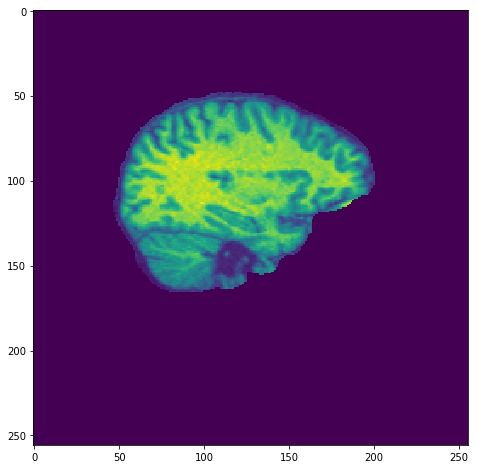

In [18]:
plt.imshow(ds.sel(subject='140820_YF58DB_FS', w=100).MRI)

In [19]:
ds['spacing'].loc[{'subject':'140820_YF58DB_FS'}] = test_data.header['delta']
ds['spacing'].loc[{'subject':'091107_UU55XU_FS'}] = test_data2.header['delta']

In [20]:
# Look at the new values
ds['spacing']

<xarray.DataArray 'spacing' (subject: 2, dw_dh_dd: 3)>
array([[1., 1., 1.],
       [1., 1., 1.]], dtype=float32)
Coordinates:
  * subject   (subject) <U16 '140820_YF58DB_FS' '091107_UU55XU_FS'
  * dw_dh_dd  (dw_dh_dd) int64 0 1 2

The values for spacing are fairly uninteresting (1mm x 1mm x 1mm for both patients), but in most datasets, these values will not be so uniform.  What we have here is a filled xArray Dataset, holding our primary data (the MRIs), secondary data (the segmentations), and additional meta-data.  All these data are associated with the correct patient, so we can call that patient by his unique id instead of an index.  This makes analysis and exploration that much easier, since all our relevant data is in one container and we can query from it using meaningful variables.

But we're still using plain old matplotlib to do our visualization.  Interactivity is minimal, and we might want to combine images (segmentation overlays, for instance) in order to better understand and explore.  Quick visual comparison is also important when we're doing data augmentation to make sure we're on the right track.

## Visualizing Image Data
Let's go beyond matplotlib.  In this section, we will explore the usage of holoviews for interactive visualization.  Holoviews works natively with xArray objects, which will be to our benefit.  We'll start simple and scale up to a simple function that handles a lot of our visualization needs.

### Simple Slice Viewing with Holoviews
Before we get too fancy, let's reproduce the type of plots we've already made in matplotlib, but using holoviews.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
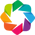

In [21]:
# Import holoviews and set up bokeh as the backend
import holoviews as hv
from holoviews import opts
hv.extension('bokeh', 'matplotlib')

In [22]:
img = hv.Image(ds.sel(w=100, subject='091107_UU55XU_FS'), vdims=['MRI'], kdims=['d', 'h'])
img.opts(invert_yaxis=True, width=500, height=500, cmap='viridis')

:Image   [d,h]   (MRI)

#### *Exercise*: Why do we have to flip the y axis? How can we do this within the data, before plotting?
https://dsp.stackexchange.com/questions/35925/why-do-we-use-the-top-left-corner-as-the-origin-in-image-processing

In [23]:
# Reverse the coordinates for x, y, z.  This gives us our standard views of the brain for axial, coronal, and sagittal.
ds = ds.assign_coords(w=range(256)[::-1], h=range(256)[::-1], d=range(256)[::-1])

In [24]:
(hv.Image(ds.sel(w=128, subject='091107_UU55XU_FS'), vdims=['MRI'], kdims=['d', 'h'], label='Sagittal')
 + hv.Image(ds.sel(h=128, subject='091107_UU55XU_FS'), vdims=['MRI'], kdims=['w', 'd'], label='Axial')
 + hv.Image(ds.sel(d=128, subject='091107_UU55XU_FS'), vdims=['MRI'], kdims=['w', 'h'], label='Coronal'))

:Layout
   .Image.Sagittal :Image   [d,h]   (MRI)
   .Image.Axial    :Image   [w,d]   (MRI)
   .Image.Coronal  :Image   [w,h]   (MRI)

### Multi-slice Viewing
So far, there's been no real benefit for using holoviews over standard matplotlib (in fact, holoviews is a little more cumbersome).  That's all about to change.  To maximize our benefit from holoviews, we'll make a holoviews dataset directly from our xarray object, and that will be used for our images.

In [25]:
# Making our holoviews dataset
hv_ds = hv.Dataset(ds['MRI'])
hv_ds

:Dataset   [subject,w,h,d]   (MRI)

In [26]:
from holoviews import opts
opts.defaults(opts.Image(cmap='viridis', width=400, height=400))
              
dyn_map = hv_ds.to(hv.Image, groupby=['subject', 'w'], dynamic=True, kdims=['d', 'h'])
print(dyn_map)
dyn_map

:DynamicMap   [subject,w]


:DynamicMap   [subject,w]
   :Image   [d,h]   (MRI)

In [27]:
# One of the downsides of using 'dynamic=True' is that holoviews can't figure out an appropriate colormap range for the whole image so, each slice has it's own.
# Let's try to do something about that.
# Note, we can get the original xarray format by calling 'data' on our holoviews dataset
print(hv_ds.data.MRI.min())
print(hv_ds.data.MRI.max())

<xarray.DataArray 'MRI' ()>
array(0., dtype=float32)
<xarray.DataArray 'MRI' ()>
array(154., dtype=float32)


In [28]:
dyn_map.redim.range(MRI=(0, 154))

:DynamicMap   [subject,w]
   :Image   [d,h]   (MRI)

In [29]:
# Making our holoviews datasets
hv_ds_MRI = hv.Dataset(ds['MRI']) # MRI
hv_ds_seg = hv.Dataset(ds['seg']) # Segmentation

In [30]:
# Make two dynamic images, plot them side by side
dyn_MRI = hv_ds_MRI.to(hv.Image, groupby=['subject', 'w'], dynamic=True, kdims=['d', 'h']).redim.range(MRI=(0,150))
dyn_seg = hv_ds_seg.to(hv.Image, groupby=['subject', 'w'], dynamic=True, kdims=['d', 'h']).opts(cmap='Category20').redim.range(seg=(0,86))
# use '+' to plot both side by side
dyn_MRI+dyn_seg

:Layout
   .DynamicMap.I  :DynamicMap   [subject,w]
      :Image   [d,h]   (MRI)
   .DynamicMap.II :DynamicMap   [subject,w]
      :Image   [d,h]   (seg)

Let's look at a particular segmentation value and see if we can isolate it.

In [31]:
# See our segmentation values
np.unique(ds['seg'], return_counts=True)

(array([  0.,   2.,   3.,   4.,   5.,   7.,   8.,  10.,  11.,  12.,  13.,
         14.,  15.,  16.,  17.,  18.,  24.,  26.,  28.,  30.,  31.,  41.,
         42.,  43.,  44.,  46.,  47.,  49.,  50.,  51.,  52.,  53.,  54.,
         58.,  60.,  62.,  63.,  72.,  77.,  80.,  85., 251., 252., 253.,
        254., 255.], dtype=float32),
 array([31242125,   433656,   484074,     6955,      293,    33354,
          106048,    14180,     7184,    12121,     3957,     1645,
            2763,    44085,     8953,     3572,     2353,     1134,
            8490,      151,     3428,   436723,   476488,     7770,
             371,    32172,   107759,    13988,     6987,    11280,
            3171,     8967,     3522,     1437,     8456,      123,
            3326,       16,     3806,       67,      580,     2049,
            1152,     1181,      928,     1592]))

In [32]:
# Select seg==2, make all the other values 0
hv_ds_seg_single = hv.Dataset(ds.where(ds.seg==2).fillna(0)['seg']) 

In [33]:
dyn_seg_single = hv_ds_seg_single.to(hv.Image, groupby=['subject', 'w'],
                                     dynamic=True, kdims=['d', 'h']).opts(cmap='Category20').redim.range(seg=(0,3))
# use '+' to plot both side by side
dyn_MRI+dyn_seg_single

:Layout
   .DynamicMap.I  :DynamicMap   [subject,w]
      :Image   [d,h]   (MRI)
   .DynamicMap.II :DynamicMap   [subject,w]
      :Image   [d,h]   (seg)

### Investigative Plots 

In [34]:
# Aggregate over multiple axes ('w' and 'subject' in this case)
hv_ds_MRI.aggregate(['d', 'h'], np.sum).to(hv.Image)

:Image   [d,h]   (MRI)

In [35]:
# Reduce over a single axes ('subject' in this case)
hv_ds_MRI.reduce(subject=np.mean).to(hv.Image, groupby='w', dynamic=True, kdims=['d', 'h']).redim.range(MRI=(0,150))

:DynamicMap   [w]
   :Image   [d,h]   (MRI)

In [36]:
hv.Spread(hv_ds_MRI.aggregate('d', np.mean, np.std)) * hv.Curve(hv_ds_MRI.aggregate('d', np.mean)).opts(
                                                                title='Mean and Std Dev of MRI values as function of D', width=500)

:Overlay
   .Spread.I :Spread   [d]   (MRI,MRI_std)
   .Curve.I  :Curve   [d]   (MRI)

In [55]:
hist = hv_ds_MRI.hist(dimension='MRI', groupby='subject', bin_range=(1, 154), bins=40, adjoin=False, log=True)
hist.opts(opts.Histogram(alpha=0.5, width=600, title='Hist of MRI Values'))

:NdOverlay   [subject]
   :Histogram   [MRI]   (MRI_frequency)

#### *Exercise*: What are the downsides of Boxplots?

In [58]:
# Let's make a violin plot and boxplot of the same distributions side by side
(hv_ds_MRI.select(d=(50,200), w=125, h=125).to(hv.Violin, 'subject', 'MRI', groupby=[]).opts(width=500, height=400, title='Violin of Selected MRI Values')
+ hv_ds_MRI.select(d=(50,200), w=125, h=125).to(hv.BoxWhisker, 'subject', 'MRI', groupby=[]).opts(width=500, height=400, title='BoxWhisker of Selected MRI Values'))


:Layout
   .Violin.I     :Violin   [subject]   (MRI)
   .BoxWhisker.I :BoxWhisker   [subject]   (MRI)

### Alpha Blending
Overlaying images on top of one another is a very useful technique for quick verification and comparison.  There are many ways to approach this, but I prefer alpha blending, in which an image with variable transparency is overlaid on another.  Let's try to accomplish that in the holoviews framework.

In [67]:
import panel as pn
# make a new hv dataset, but set all 0s to NaNs (NaNs are transparent)
hv_ds_seg_overlay = hv.Dataset(ds.where(ds.seg>0)['seg']) 
dyn_seg_overlay = hv_ds_seg_overlay.to(hv.Image, groupby=['subject', 'w'],
                                     dynamic=True, kdims=['d', 'h']).opts(cmap='Category20').redim.range(seg=(0,86))

# Make an alpha slider
slider = pn.widgets.FloatSlider(start=0, end=1, value=0.0, name='mask')
# Plot the slider and the overlayed images using the '*' operator
pn.Column(slider, dyn_MRI.redim.range(MRI=(0,150))*dyn_seg_overlay.apply.opts(alpha=slider.param.value))

/home/bpollack/conda_envs/data_course/lib/python3.6/site-packages/xarray/core/nputils.py:222: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwds)
/home/bpollack/conda_envs/data_course/lib/python3.6/site-packages/xarray/core/nputils.py:222: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwds)
/home/bpollack/conda_envs/data_course/lib/python3.6/site-packages/xarray/core/nputils.py:222: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwds)
/home/bpollack/conda_envs/data_course/lib/python3.6/site-packages/xarray/core/nputils.py:222: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwds)


Column
    [0] FloatSlider(end=1, name='mask', start=0, value=0.0)
    [1] Row
        [0] HoloViews(DynamicMap)
        [1] Column
            [0] Select(name='subject', options=['091107_UU55XU_FS', ...], value='091107_UU55XU_FS')
            [1] DiscreteSlider(formatter='%d', name='w', options=OrderedDict([('0', ...]), value=0)

## Scaling Up